In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

In [2]:
data_1 = pd.read_csv("/Volumes/TwoTeras/0_Experiment_1/Entropy_Results/entropy_log_Window_reduced.csv")
data_2 = pd.read_csv("/Volumes/TwoTeras/1_Experiment_2/Entropy_Results/entropy_log_Window_reduced.csv")
data_1.drop_duplicates(inplace=True)
data_2.drop_duplicates(inplace=True)

In [3]:
stacked_df = pd.concat([data_1,data_2])

In [4]:
stacked_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10536 entries, 0 to 5612
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Trial_ID                    10536 non-null  object 
 1   Collider_Name               10536 non-null  object 
 2   Occurrence_Order            10536 non-null  int64  
 3   Overall_Transition_Entropy  10536 non-null  float64
 4   Participant_ID              10536 non-null  int64  
 5   Session                     10536 non-null  int64  
 6   Agent_ID                    10536 non-null  int64  
 7   Agent_Type                  10536 non-null  object 
 8   Experiment                  10536 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 823.1+ KB


In [5]:
data_2.head()

Trial_ID Collider_Name  Occurrence_Order  \
0  01_Cma_Trial_22        01_Cma                22   
1  03_Cma_Trial_16        03_Cma                16   
2  09_Cma_Trial_14        09_Cma                14   
3  09_Cma_Trial_24        09_Cma                24   
4  09_Cma_Trial_26        09_Cma                26   

   Overall_Transition_Entropy  Participant_ID  Session  Agent_ID Agent_Type  \
0                    0.494550            1031        1         1     Active   
1                    0.340640            1031        1         3     Active   
2                    0.250472            1031        1         9     Active   
3                    0.334480            1031        1         9     Active   
4                    0.314868            1031        1         9     Active   

   Experiment  
0           2  
1           2  
2           2  
3           2  
4           2

In [6]:
# Sort the data
stacked_df_ordered = stacked_df.sort_values(by=["Participant_ID", "Session", "Occurrence_Order"])


# Create Encounter_Order
stacked_df_ordered["Encounter_Order"] = (
    stacked_df_ordered.groupby(["Participant_ID", "Session", "Agent_ID"])
    .cumcount() + 1
)


In [7]:
stacked_df_ordered.head()

Trial_ID Collider_Name  Occurrence_Order  \
4453   46_Sa_Trial_1         46_Sa                 1   
4440  15_Cma_Trial_2        15_Cma                 2   
4457   51_Sa_Trial_3         51_Sa                 3   
4454   47_Sa_Trial_4         47_Sa                 4   
4433  06_Cma_Trial_5        06_Cma                 5   

      Overall_Transition_Entropy  Participant_ID  Session  Agent_ID  \
4453                    0.314116             365        1        46   
4440                    0.442577             365        1        15   
4457                    0.489724             365        1        51   
4454                    0.584306             365        1        47   
4433                    0.609034             365        1         6   

     Agent_Type  Experiment  Encounter_Order  
4453    Passive           1                1  
4440     Active           1                1  
4457    Passive           1                1  
4454    Passive           1                1  
4433     Active           1                1

In [17]:
stacked_df_ordered.columns

Index(['Trial_ID', 'Collider_Name', 'Occurrence_Order',
       'Overall_Transition_Entropy', 'Participant_ID', 'Session', 'Agent_ID',
       'Agent_Type', 'Experiment', 'Encounter_Order'],
      dtype='object')

In [29]:
import numpy as np
import pandas as pd
import skfda
from skfda.representation.basis import FourierBasis
from skfda.preprocessing.smoothing import BasisSmoother



# Reshape data: We need entropy values as a function of time (Occurrence_Order)
time_points = stacked_df_ordered["Occurrence_Order"].values
entropy_values = stacked_df_ordered["Overall_Transition_Entropy"].values

# Create a Fourier Basis (smooth functional representation)
basis = FourierBasis(domain_range=(min(time_points), max(time_points)), n_basis=6)

# Fit the entropy data using FDA smoothing
fd = skfda.FDataGrid(data_matrix=entropy_values.reshape(-1, 1), grid_points=time_points)
smoother = BasisSmoother(basis)
fd_smooth = smoother.fit_transform(fd)

# Plot smoothed entropy trajectories
fd_smooth.plot()


ModuleNotFoundError: No module named 'skfda'

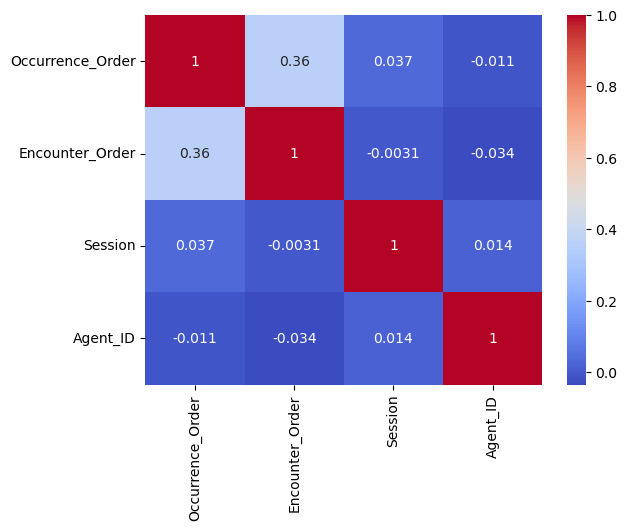

In [23]:
stacked_df_ordered["Agent_ID"] = stacked_df_ordered["Agent_ID"].astype("category")
sns.heatmap(stacked_df_ordered[["Occurrence_Order", "Encounter_Order", "Session", "Agent_ID"]].corr(), annot=True, cmap="coolwarm")
plt.show()

In [26]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
model = smf.mixedlm("Overall_Transition_Entropy ~ Encounter_Order + Session + C(Agent_ID)", 
                     stacked_df_ordered, groups=stacked_df_ordered["Participant_ID"])
result = model.fit()
print(result.summary())  # Check model results

                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Overall_Transition_Entropy
No. Observations: 10536   Method:             REML                      
No. Groups:       59      Scale:              0.0130                    
Min. group size:  89      Log-Likelihood:     7659.0119                 
Max. group size:  304     Converged:          Yes                       
Mean group size:  178.6                                                 
--------------------------------------------------------------------------
                      Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
--------------------------------------------------------------------------
Intercept              0.427      0.009   47.665   0.000    0.409    0.444
C(Agent_ID)[T.2]       0.013      0.011    1.182   0.237   -0.009    0.035
C(Agent_ID)[T.3]      -0.058      0.012   -4.883   0.000   -0.081   -0.035
C(Agent_ID)[T.4]      -0.065      0.013   -4.804   0.000 

/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [27]:
# Fit a mixed-effects growth curve model
model = smf.mixedlm("Overall_Transition_Entropy ~ Session + Agent_Type + Occurrence_Order + Encounter_Order + I(Occurrence_Order**2)",
                     stacked_df_ordered, groups=stacked_df_ordered["Participant_ID"], re_formula="~Occurrence_Order")
result = model.fit()
print(result.summary())  # Check model results

/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Overall_Transition_Entropy
No. Observations: 10536   Method:             REML                      
No. Groups:       59      Scale:              0.0136                    
Min. group size:  89      Log-Likelihood:     7363.2672                 
Max. group size:  304     Converged:          No                        
Mean group size:  178.6                                                 
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.421    0.005 76.741 0.000  0.411  0.432
Agent_Type[T.Passive]          0.005    0.002  2.272 0.023  0.001  0.010
Session                        0.002    0.001  1.858 0.063 -0.000  0.003
Occurrence_Order              -0.000    0.005 -0.092 0.927 -0.011  0.

/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 200.536626
  warnings.warn(msg, ConvergenceWarning)
/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/tracysanchezpacheco/anaconda3/lib/pyth

In [8]:
# Filter out values less than 0.001
filtered_df = stacked_df_ordered[(stacked_df_ordered['Overall_Transition_Entropy'] >= 0.001)]

# Group by Agent_ID, Participant_ID, and Session
grouped_by_session = stacked_df_ordered.groupby(
    ['Agent_ID', 'Agent_Type', 'Participant_ID', 'Session', 'Experiment']
)['Overall_Transition_Entropy'].agg(['min', 'max', 'median', 'mean']).reset_index()

# Group by Agent_ID and Participant_ID (not separated by Session)
grouped_without_session = stacked_df_ordered.groupby(
    ['Agent_ID', 'Agent_Type', 'Participant_ID', 'Experiment']
)['Overall_Transition_Entropy'].agg(['min', 'max', 'median', 'mean']).reset_index()

grouped_for_LMM = stacked_df_ordered.groupby(
    ['Agent_ID', 'Agent_Type', 'Participant_ID', 'Experiment']
)['Overall_Transition_Entropy'].agg(['min', 'max', 'median', 'mean']).reset_index()


In [9]:
grouped_for_LMM.Experiment.value_counts()

Experiment
2    1546
1    1505
Name: count, dtype: int64

In [10]:
grouped_for_LMM.head()
grouped_for_LMM.to_csv("/Volumes/TwoTeras/1_Experiment_2/Entropy_Results/grouped_for_LMM.csv")

In [11]:
Chao = pd.read_csv("/Volumes/TwoTeras/1_Experiment_2/Entropy_Results/grouped_for_LMM_Chao_Shen.csv")

In [12]:
Chao.head()

Unnamed: 0  Agent_ID Agent_Type  Participant_ID  Experiment       min  \
0           0         1     Active             365           1  2.285714   
1           1         1     Active             479           1  1.066667   
2           2         1     Active            1031           2  1.294249   
3           3         1     Active            1142           2  0.636430   
4           4         1     Active            1234           2  0.896440   

        max    median      mean  
0  2.628756  2.457235  2.457235  
1  3.549732  1.639768  1.880813  
2  2.423025  1.696149  1.707393  
3  2.628756  1.274585  1.415056  
4  2.285714  2.053292  1.822185

In [13]:
grouped_for_LMM.head()

Agent_ID Agent_Type  Participant_ID  Experiment       min       max  \
0         1     Active             365           1  0.372353  0.538183   
1         1     Active             479           1  0.000000  0.579128   
2         1     Active            1031           2  0.357113  0.560169   
3         1     Active            1142           2  0.280231  0.659876   
4         1     Active            1234           2  0.248320  0.532339   

     median      mean  
0  0.381124  0.430553  
1  0.347142  0.367965  
2  0.514027  0.491440  
3  0.525075  0.512275  
4  0.470402  0.430366

<Axes: xlabel='Agent_ID', ylabel='mean'>

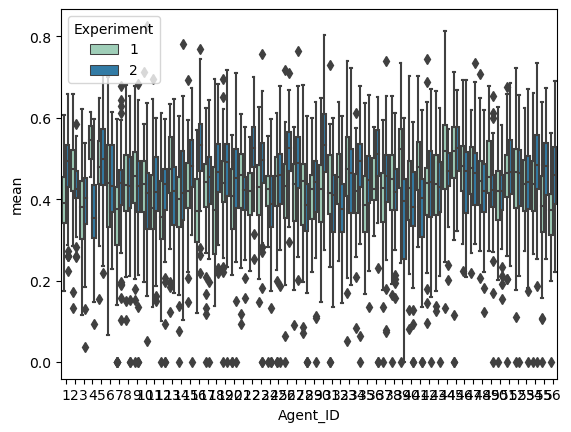

In [14]:
# Generate a palette with two colors, one for each experiment
experiment_palette = sns.color_palette("YlGnBu", 2)
sns.boxplot(data=grouped_by_session, x='Agent_ID', y='mean', hue='Experiment', palette=experiment_palette)

/var/folders/3p/lxg47mnx0ks_st66vkzkx1640000gn/T/ipykernel_6602/4235266660.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_by_session_Active["Experiment_Type"] = grouped_by_session_Active["Experiment"].apply(lambda x: "Congruent" if x == 1 else "Incongruent")


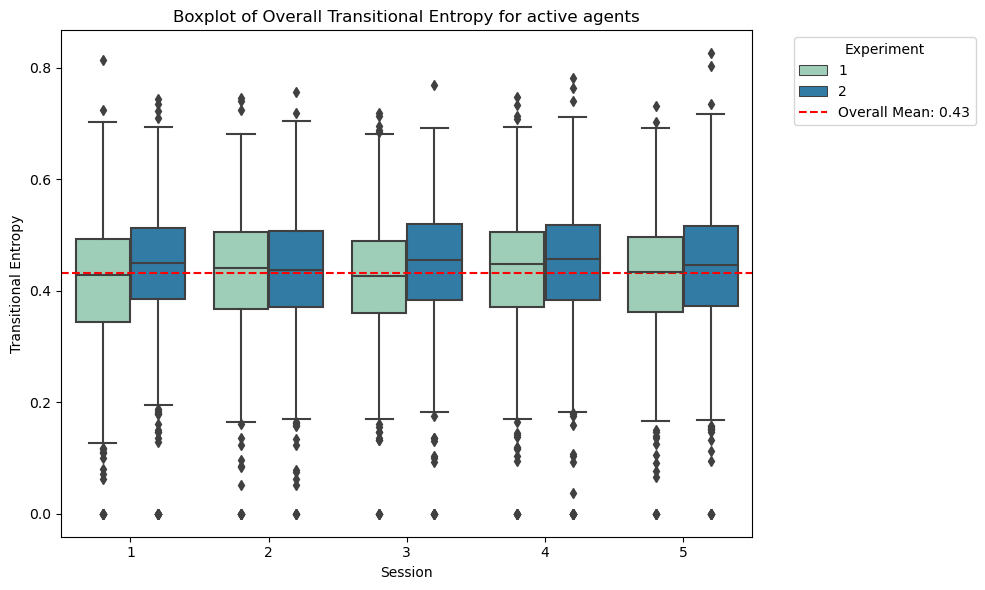

In [15]:


# Generate a palette with two colors, one for each experiment
experiment_palette = sns.color_palette("YlGnBu", 2)
grouped_by_session_Active = grouped_by_session[grouped_by_session.Agent_Type == "Active"]
# Add a new column for Experiment_Type
grouped_by_session_Active["Experiment_Type"] = grouped_by_session_Active["Experiment"].apply(lambda x: "Congruent" if x == 1 else "Incongruent")


# Calculate the overall mean of Transition_Entropy_Active_Agent
overall_mean = grouped_by_session_Active['mean'].mean()

# Plotting combined boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_by_session, x='Session', y='mean', hue='Experiment', palette=experiment_palette)

# Add a red horizontal line for the overall mean
plt.axhline(overall_mean, color='red', linestyle='--', linewidth=1.5, label=f'Overall Mean: {overall_mean:.2f}')

# Set labels and title
plt.title("Boxplot of Overall Transitional Entropy for active agents")
plt.xlabel("Session")
plt.ylabel("Transitional Entropy")
plt.legend(title="Experiment", loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

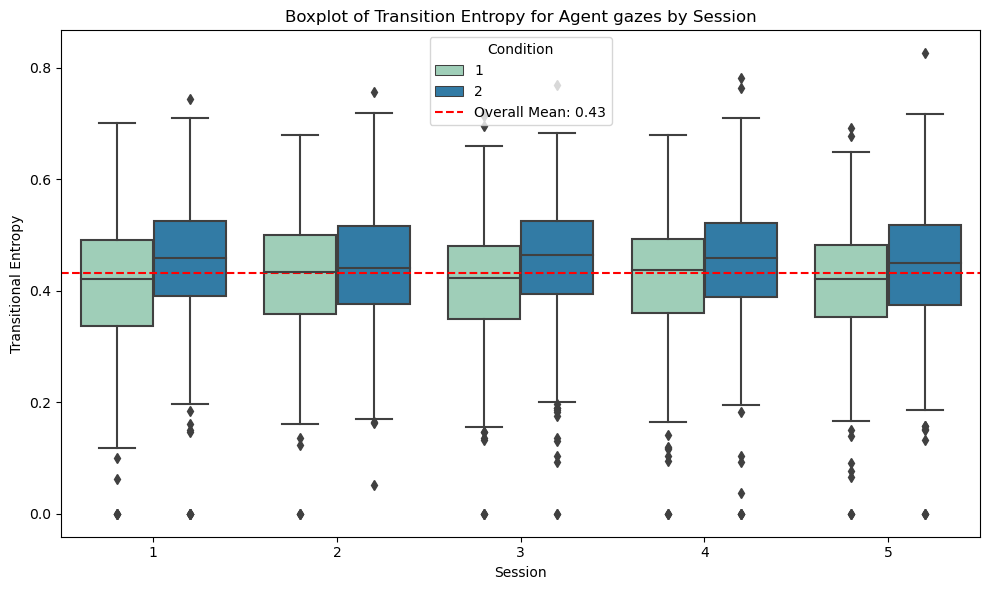

In [16]:
grouped_by_session_active = grouped_by_session[grouped_by_session.Agent_Type == "Active"]

# Generate a palette with two colors, one for each experiment
experiment_palette = sns.color_palette("YlGnBu", 2)

# Calculate the overall mean of Transition_Entropy_Active_Agent
overall_mean = grouped_by_session_active['mean'].mean()

# Plotting combined boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_by_session_active, x='Session', y='mean', hue='Experiment', palette=experiment_palette)

# Add a red horizontal line for the overall mean
plt.axhline(overall_mean, color='red', linestyle='--', linewidth=1.5, label=f'Overall Mean: {overall_mean:.2f}')

# Set labels and title
plt.title("Boxplot of Transition Entropy for Agent gazes by Session")
plt.xlabel("Session")
plt.ylabel("Transitional Entropy")
plt.legend(title="Condition")
plt.tight_layout()
plt.show()